<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/Sesssion5_MNIST/EVA4_S5_F4_GAPLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

---
Convolution layer was being used as the last layer. Use GAP to reduce the last big layer. Since model's capacity is reduced, add another convolution block after GAP to increase capacity.

Results:

---
1. Number of parameters: 9.5K
2. Training accuracy : 98.92%
3. Testing accuracy : 99.15%

Analysis:

---



1. Test accuracy is still not achieving desired value. Model is not showing any overfitting. Shows model is trained harder. 

---



Importing Libraries

In [0]:
#A future statement is a directive to the compiler that a particular module should be compiled using syntax or semantics that will be available in a specified future release of Python.
from __future__ import print_function

# torch is the main module that holds all the things you need for Tensor computation.
import torch

# nn module provides many classes and functions to build neural networks.
# models, all kinds of layers, activation functions, parameter classes, etc
import torch.nn as nn

# functional api such as relu
import torch.nn.functional as F

# it offers all the optimizers like SGD, ADAM
import torch.optim as optim

#Torchvision is a package in the PyTorch library containing computer-vision models, datasets, and image transformations
from torchvision import datasets, transforms

#Matplotlib for graphs.
import matplotlib.pyplot as plt

Data Transformations

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


The model

In [0]:
dropout_value = 0.25
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Convolution layer-1  
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8)                        
        ) #Output size- 28. RF=3

        #Convolution layer-2
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) #Output size- 28. RF=5

        #Convolution layer-2
        self.conv21 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) #Output size- 28. RF=7

        #Max pool, Transition block and dropout - 1
        self.conv3 = nn.Sequential( 
            #Transition layer - start
            nn.MaxPool2d(2, 2), #Output size- 14. RF=8
            nn.Conv2d(16, 8, 1),  #Output size- 14. RF=8          
            nn.Dropout(0.25)
        ) 

        #Convolution Layer-3
        self.conv4 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1), #Output size- 14. RF=12 
            nn.ReLU(),
            nn.BatchNorm2d(8)             
        ) 
        
        #Convolution Layer-4
        self.conv5 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1), #Output size- 14. RF=16 
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        #Convolution layer-2
        self.conv51 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1), #Output size- 14. RF=20
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) 

        #Max pool, Transition block and dropout - 1
        self.conv6 = nn.Sequential(
            #Transition layer - start
            nn.MaxPool2d(2, 2), #Output size- 7. RF=22 
            nn.Conv2d(16, 8, 1), #Output size- 7. RF=22
            #Transition layer - End
            nn.Dropout(0.25)
        )

        #Convolution Layer-5
        self.conv7 = nn.Sequential(
            nn.Conv2d(8, 16, 3), #Output size- 5. RF=30
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        #Convolution layer-6
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

        #Final Layer
        self.conv9 = nn.Sequential(
           nn.Conv2d(16,10,1) #Output size- 1. 
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv21(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv51(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.gap(x)
        x = self.conv9(x)

        
                      
        # Flatten layer
        x = x.view(-1, 10)
        return F.log_softmax(x)

Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 16, 28, 28]           1,168
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 16, 28, 28]           2,320
              ReLU-8           [-1, 16, 28, 28]               0
       BatchNorm2d-9           [-1, 16, 28, 28]              32
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             136
          Dropout-12            [-1, 8, 14, 14]               0
           Conv2d-13            [-1, 8, 14, 14]             584
             ReLU-14            [-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
#from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.15342403948307037 Batch_id=468 Accuracy=82.06: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1005, Accuracy: 9736/10000 (97.36%)

EPOCH: 1


Loss=0.07030118256807327 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:12<00:00, 36.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0799, Accuracy: 9769/10000 (97.69%)

EPOCH: 2


Loss=0.05252319946885109 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:12<00:00, 36.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0607, Accuracy: 9834/10000 (98.34%)

EPOCH: 3


Loss=0.11950365453958511 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:13<00:00, 41.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9858/10000 (98.58%)

EPOCH: 4


Loss=0.04344676062464714 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9862/10000 (98.62%)

EPOCH: 5


Loss=0.056131284683942795 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9865/10000 (98.65%)

EPOCH: 6


Loss=0.03559734299778938 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9871/10000 (98.71%)

EPOCH: 7


Loss=0.024774888530373573 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.18676750361919403 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.027604246512055397 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 40.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.03864303231239319 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9886/10000 (98.86%)

EPOCH: 11


Loss=0.03304832801222801 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.02812534011900425 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.014329428784549236 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.0548047237098217 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]



Test set: Average loss: 0.0319, Accuracy: 9905/10000 (99.05%)



Let's Train and test our model

Text(0.5, 1.0, 'Test Accuracy')

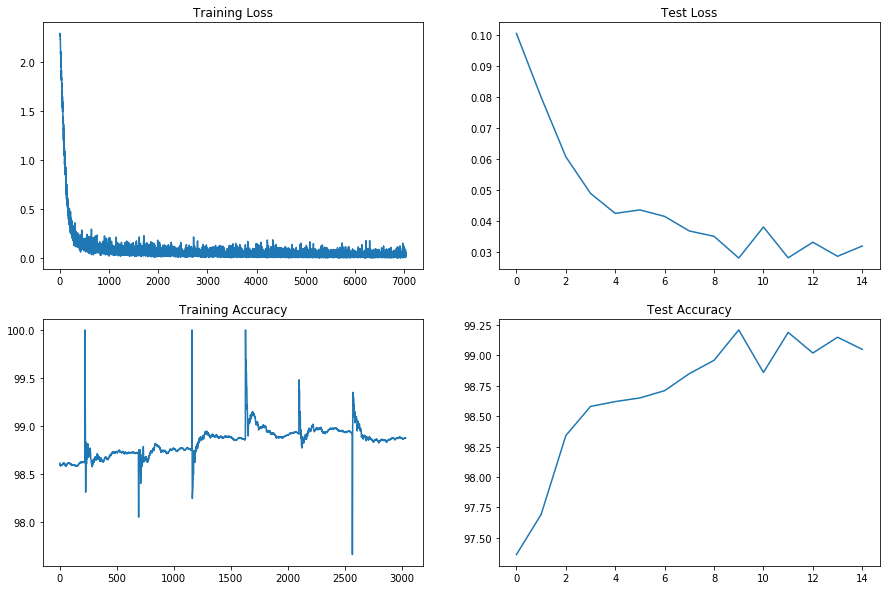

In [9]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")